In [743]:
import pandas as pd
import numpy as np
from sargas import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
%matplotlib inline

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'legend.frameon':False})

In [669]:
def run_simulation(run_number, production_steps=50000):
    """Run a NVT Monte-Carlo simulation with control variables defined inside this function."""
    # define ensemble control variables
    nparticles = 256
    density = 0.5
    temperature = 2.0
    rc = 3.0
    tail_correction = True

    # build configuration, system and simulation
    potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=tail_correction)
    configuration = Configuration.from_lattice(nparticles, density)
    system = System(configuration, potential)
    displace_particle = MCMove.displace_particle(0.1, 0.4, temperature)
    mc = MonteCarlo([displace_particle], [1], temperature)
    simulation = Simulation.monte_carlo(system, mc, nparticles)
    
    equilibration, production = nparticles * 5000, nparticles * production_steps
    # run equilibration
    simulation.run(equilibration)
    # stop updating the maximum displacement
    simulation.deactivate_propagator_updates()
    
    # add observer to compute all properties
    properties = Observer.properties(1000)
    simulation.add_observer(properties)
    # run production 
    simulation.run(production)
    
    # put results into dataframe and add run number
    results = pd.DataFrame(properties.data)
    results['run'] = run_number
    return results

def plot_distributions(data, prop):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    pal = sns.cubehelix_palette(len(data.groupby("run")), rot=-.25, light=.7)
    g = sns.FacetGrid(data.reset_index(), row="run", hue="run", aspect=15, height=.5, palette=pal)
    g.map(sns.kdeplot, prop,
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, prop, clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, prop)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set(xticks=[])
    g.despine(bottom=True, left=True);

# Assesing statistical uncertainties in molecular simulations <a class="anchor" id="top"></a>

## Content

* [Introduction](#introduction)
* [Run multiple simulations](#run-multiple-simulations)
* [Second Bullet Header](#second-bullet)

## Introduction <a class="anchor" id="introduction"></a>

$\uparrow$[Back to top](#top)

Often, the goal of a molecular simulation is the **estimation of a system property**. In this notebook, we are interested in system properties that can be **estimated by averaging *instantaneous values*** which are computed from *single microstates* (i.e. $3N$ positions and possibly $3N$ velocities):

\begin{equation}
\langle A \rangle = \frac{1}{n}\sum_{i=1}^{n} A(\mathbf{x}_i) \,
\end{equation}

where $\langle A \rangle$ denotes the ensemble average of property $A$, $n$ is the number of microstates, and $\mathbf{x}_i$ denotes the $i$'th microstate. There some things to note here:

1. This equation is only correct if the microstates, $\mathbf{x}_i$, are created according to the desired ensemble probability density (for example in a Monte-Carlo simulation), and
2. *the true* value for $\langle A \rangle$ can only we calculated if we gather *all* microstates (a very large or infinite number).
3. **In a simulation, we can merely estimate** the true value of $\langle A \rangle$ because we gather a small, finite number of microstates, called **a sample**. Consequently, **the sample estimate carries a *statistical uncertainty***.

In what follows, we discuss different ways to report the statistical uncertainty of the mean of a property.

## Sample distibution versus sampling distribution

Technically, we have to distinguish between the ensemble average of the **population** and a **sample**. We use the notation

- $\langle A \rangle$ for the ensemble average of the **population**, as computed from infinitely many microstates and
- $\bar{A}$ for the mean of a **sample**, i.e. a finite subset of the population, which is what we produce in a simulation run.

The *mean* of a *sample* is called *a statistic*. It is a *numerical summary of a sample* - a function that takes multiple values and produces a single value. Other examples for statistics are the sample *median* or *range*. Statistics are different from *population parameters* ($\langle A \rangle$ is a parameter of the population) in that they **have a distribution**. 

Imagine conducting 5 simulations (with different random seeds), each yielding a sample of the potential energy. For each sample, we can compute the sample mean of the potential energy - these 5 mean values will be different.

If equation

\begin{equation}
\langle A \rangle = \frac{1}{n}\sum_{i=1}^{n} A(\mathbf{x}_i) \,
\end{equation}

describes the mean of the sample, we can compute the **sample standard deviation** via

\begin{equation}
\sigma_A = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n} (A(\mathbf{x}_i) - \langle A \rangle)^2 \,}
\end{equation}

An example for a property from a single microstate is the *potential energy* which is the sum over all (unique) pair energies (when multibody energies are not considered) that only require the partile's positions. An example for a property that requires a time series of microstates is the *diffusion coefficient* for which the time correlation function, i.e. a function of *simulation time*, is required. In this notebook, we are interested in estimating the *mean* and *statistial uncertainty* of properties, where insta

In a simulation we typically write the properties that we are interest in into a file.

- Multiple independent simulation runs
- Simple block averaging
- The method of Flyvbjerg and Petersen
- Using the correlation time

# Run multiple simulations <a class="anchor" id="run-multiple-simulations"></a>

In [670]:
# this runs simulations in parallel (using all available cores)
# and gathers results in a pandas dataframe
number_of_simulations = 25
with Pool() as p:
    # simulations = pd.concat(p.map(run_simulation, range(number_of_simulations)))
    simulations = pd.concat(tqdm(p.imap(run_simulation, range(number_of_simulations)), total=number_of_simulations))
    
simulations['step'] = simulations.index
simulations.set_index(['run', 'step'], inplace=True)

100%|██████████| 25/25 [07:23<00:00, 17.73s/it]


In [864]:
# store to file
simulations.to_pickle("multiple_simulations_for_uncertainties.pkl.gz")

In [865]:
# uncomment to load from file
# simulations = pd.read_pickle("multiple_simulations_for_uncertainties.pkl.gz")

## Plot **sample distribution** of the energy for each simulation

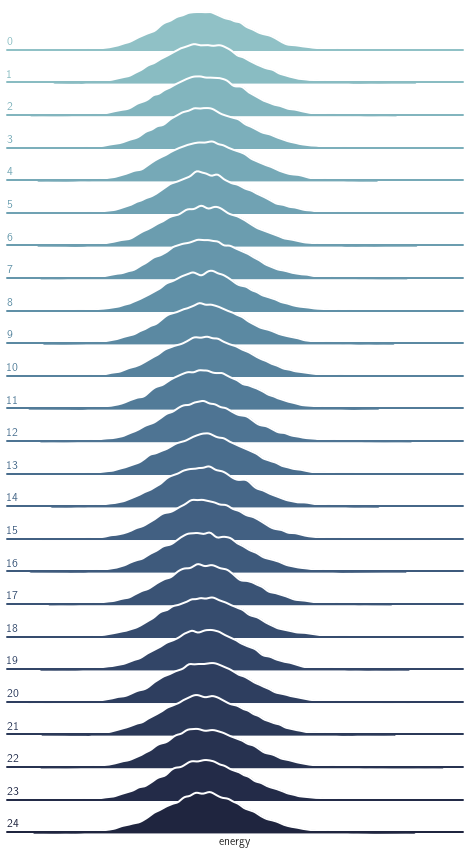

In [671]:
plot_distributions(simulations, "energy")

## Plot **sampling distribution of the mean** of the energy

In [672]:
statistics = simulations.groupby('run').energy.describe()

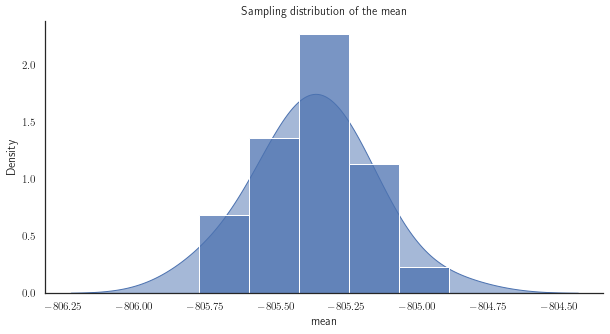

In [675]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=statistics, x="mean", bw_adjust=1.5, fill=True, alpha=0.5, ax=ax, label="density")
sns.histplot(data=statistics, x="mean", bins=5, stat="density", ax=ax, label="histogram")
ax.set_title("Sampling distribution of the mean");
sns.despine()

## Estimate the **standard error** from the **sampling distribution**

The **standard error** is the **standard deviation** of the **sampling distribution**.

In [676]:
se_sampling_distribution = statistics["mean"].std()
ci_sampling_distribution = 1.96 * se_sampling_distribution
print('SE(SD of sampling distribution) = {:.4f}'.format(se_sampling_distribution))
print('95 % CI = {:.4f}'.format(ci_sampling_distribution))

SE(SD of sampling distribution) = 0.1923
95 % CI = 0.3770


## Blocking method of Flyvbjerg and Petersen
Evaluate one simulation.

In [848]:
fp_simulation = simulations.loc[23]# run_simulation("fp", production_steps=50000)

In [849]:
def grouper(iterable, n, fillvalue=None):
    from itertools import zip_longest
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)


def flyvbjerg_petersen(data):
    n_data = len(data)
    block = data
    se = np.sqrt(np.var(block) / (n_data - 1))
    dse = 1.0 / np.sqrt(2 * (n_data - 1))
    interval = pd.Interval(se-dse, se+dse, "both")
    result = [(1, se, dse, interval)]
    while len(block) > 4:
        block = np.fromiter(filter(np.isfinite, map(np.mean, grouper(block, 2, np.NaN))), dtype=float)
        n = len(block) # number of blocks'
        se = np.sqrt(np.var(block) / (n - 1))
        dse = 1.0 / np.sqrt(2 * (n - 1))
        interval = pd.Interval(se-dse, se+dse, "both")
        result.append((n_data // n, se, dse, interval))
        
    df = pd.DataFrame(result, columns=["block", "se", "dse", "interval"])
    
    # test (starting from "left") if intervals overlap
    for i, interval in enumerate(df.interval.values):
        if all(map(interval.overlaps, df.interval.values[i:])):
            break
            
    return df.iloc[i].se, df

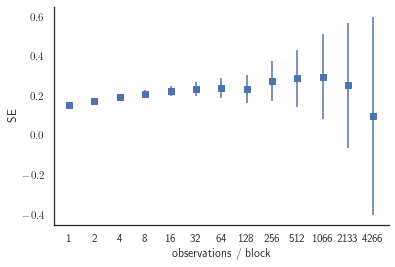

In [850]:
se_fp, fp = flyvbjerg_petersen(fp_simulation.energy)
plt.errorbar(fp.index, fp.se, yerr=fp.dse, fmt="s")
plt.xticks(fp.index, fp.block);
plt.xlabel("observations / block")
plt.ylabel("SE")
sns.despine()

In [853]:
fp

,block,se,dse,interval
0,1,0.156746,0.006250,"[0.15049617267344736, 0.16299666098330948]"
1,2,0.175957,0.008840,"[0.16711782651872228, 0.18479687727818297]"
2,4,0.193648,0.012502,"[0.1811460241417731, 0.20614993130753895]"
3,8,0.211438,0.017683,"[0.1937551622242449, 0.22912155500873196]"
4,16,0.227126,0.025016,"[0.2021105344627523, 0.2521418137901783]"
5,32,0.237142,0.035400,"[0.201742580536647, 0.2725418130771259]"
6,64,0.239210,0.050125,"[0.18908432014346563, 0.2893352615668827]"
7,128,0.234472,0.071067,"[0.16340475097111362, 0.3055385618748539]"
8,256,0.278085,0.101015,"[0.17706932624700422, 0.3790998351574464]"
9,512,0.290054,0.144338,"[0.1457161600767938, 0.43439129467160675]"


In [854]:
print('SE(Flyvbjerg + Petersen) = {:.4f}'.format(se_fp))
print('95 % CI = {:.4f}'.format(ci_fp))

SE(Flyvbjerg + Petersen) = 0.1936
95 % CI = 0.4821


## Autocorrelation time

In [855]:
from pymbar import timeseries

tau_ts = timeseries.integratedAutocorrelationTime(fp_simulation.energy, fast=True)
se_ts = fp_simulation.energy[::max((1, int(2.0 * tau_ts)))].sem(ddof=0)
ci_ts = 1.96 * se_ts
print('Autocorrelation time: {:.4f}'.format(tau_ts))
print('SE(timeseries) = {:.4f}'.format(se_ts))
print('95 % CI = {:.4f}'.format(ci_ts))

Autocorrelation time: 1.0381
SE(timeseries) = 0.2217
95 % CI = 0.4346


## Block Averaging

In [856]:
block_sizes = [10, 25, 50, 100, 150, 200, 300, 500]
simulation_var = fp_simulation.energy.var()
block_var = []

for b in block_sizes:
    means = np.fromiter(filter(np.isfinite, map(np.mean, grouper(fp_simulation.energy, b, np.NaN))), dtype=float)
    block_var.append((b, means.var(), simulation_var / b))

block_method = pd.DataFrame(block_var, columns=["blocksize", "block_variance", "vbfrac"])
model = np.polyfit(block_method.vbfrac[:-1], block_method.block_variance[:-1], 1)

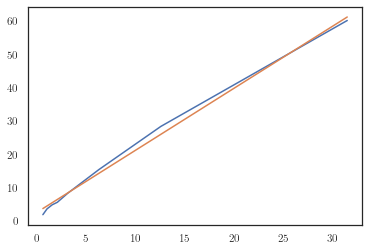

In [857]:
plt.plot(block_method.vbfrac, block_method.block_variance)
plt.plot(block_method.vbfrac, model[1] + block_method.vbfrac * model[0]);

In [858]:
tau_fit = 0.5 * model[0]
se_fit = fp_simulation.energy[::int(2*tau)].sem(ddof=0)
ci_fit = 1.96 * se_fit
print('Autocorrelation time: {:.4f}'.format(tau_fit))
print('SE(fit) = {:.4f}'.format(se_fit))
print('95 % CI = {:.4f}'.format(ci_fit))

Autocorrelation time: 0.9321
SE(fit) = 0.2217
95 % CI = 0.4346


## Empirical Bootstrapping

In [859]:
number_of_bootstrap_samples = 2000
bootstrap = pd.DataFrame(pd.Series(
    map(lambda _: fp_simulation.energy.sample(n=len(fp_simulation), replace=True).mean(), range(number_of_bootstrap_samples)),
    name="resample"
))

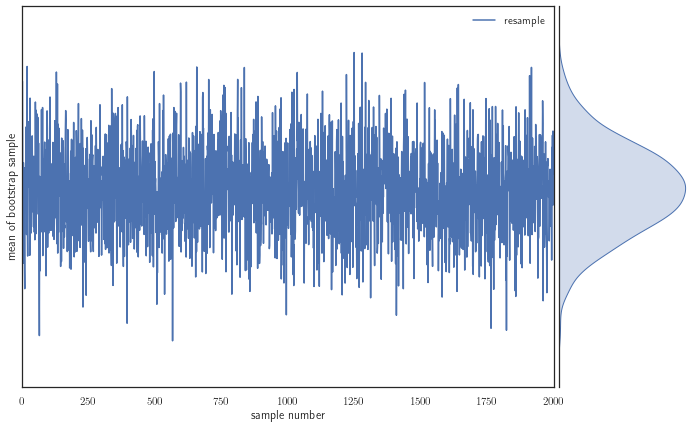

In [860]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

plt.subplots_adjust(wspace=0.015)
sns.lineplot(data=bootstrap, ax=ax[0])
sns.kdeplot(data=bootstrap, y="resample", fill=True, ax=ax[1]);
sns.despine(ax=ax[1], bottom=True)
ax[0].set_xlim([0, number_of_bootstrap_samples])
ax[0].set_xlabel("sample number")
ax[0].set_ylabel("mean of bootstrap sample")
ax[1].set_xlabel("")
ax[1].set_ylabel("bootstrap distribution")
ax[1].set_xticks([]);
ax[1].set_yticks([]);

In [861]:
ci_bootstrap = max((fp_simulation.energy.mean() - bootstrap_sample.quantile([0.025])).values, (bootstrap_sample.quantile([0.975]) - fp_simulation.energy.mean()).values)[0]
print('95 % CI = {:.4f}'.format(ci_bootstrap))

95 % CI = 0.4512


# Summary

In [862]:
print('sampling distribution:         <U> = {:.2f} +- {:.2f}'.format(simulations.energy.mean(), ci_sampling_distribution))
print('Flyvbjerg & Petersen:          <U> = {:.2f} +- {:.2f}'.format(fp_simulation.energy.mean(), ci_fp))
print('correlation time (timeseries): <U> = {:.2f} +- {:.2f}'.format(fp_simulation.energy.mean(), ci_ts))
print('correlation time (fit):        <U> = {:.2f} +- {:.2f}'.format(fp_simulation.energy.mean(), ci_fit))
print('empirical bootstrapping:       <U> = {:.2f} +- {:.2f}'.format(fp_simulation.energy.mean(), ci_bootstrap))

sampling distribution:         <U> = -805.37 +- 0.38
Flyvbjerg & Petersen:          <U> = -805.61 +- 0.48
correlation time (timeseries): <U> = -805.61 +- 0.43
correlation time (fit):        <U> = -805.61 +- 0.43
empirical bootstrapping:       <U> = -805.61 +- 0.45


In [231]:

import numpy as np
import warnings

def block_transformation(series):
    """
    Do a single step of fp block averaging.
    Parameters
    ----------
    series : ndarray
        Things we want to average: e.g. squared displacements to calculate the
        mean squared displacement of a Brownian particle.
    Returns
    -------
    blocked_series : ndarray
        an array of half the length of series with adjacent terms averaged
    Notes
    -----
    Flyvbjerg & Peterson 1989, equation 20
    """
    n_steps = series.size
    n_steps_p = int(np.floor(n_steps/2.))
    output = 0.5 * (series[::2][:n_steps_p] + series[1::2][:n_steps_p])
    return output

def calculate_blocked_variances(series, npmin = 15):
    """
    Compute a series of blocks and variances.
    Parameters
    ----------
    series : ndarray
        the thing we want to average: e.g. squared
        displacements for a Brownian random walk.
    npmin : int
        cutoff number of points to stop blocking
    Returns
    -------
    output_var, var_stderr : ndarray
        The variance and stderr of the variance at each blocking level
    Notes
    -----
    Flyvbjerg & Peterson suggest continuing blocking down to 2 points, but the
    last few blocks are very noisy, so we default to cutting off before that.
    """
    n_steps = series.size

    def var(d, n):
        # see eq. 27 of FP paper
        return d.var()/(n-1)
    def stderr_var(n):
        # see eq. 27 of FP paper
        return np.sqrt(2./(n-1))

    output_var = np.array([var(series, n_steps)]) # initialize
    var_stderr = np.array([stderr_var(n_steps)])

    while n_steps > npmin:
        series = block_transformation(series)
        n_steps = series.size
        # TODO: precompute size of output_var and var_stderr from n_steps
        # rather than appending
        output_var = np.append(output_var, var(series, n_steps))
        var_stderr = np.append(var_stderr, stderr_var(n_steps))

    return output_var, var_stderr

def detect_fixed_point(fp_var, fp_sev, full_output = False):
    """
    Find whether the block averages decorrelate the data series to a fixed
    point.
    Parameters
    ----------
    fp_var: ndarray
        FP blocked variance
    fp_sev: ndarray
        FP standard error of the variance.
    Returns
    -------
    best_var : float
        best estimate of the variance
    converged : bool
        did the series converge to a fixed point?
    bounds : (int, int) only if full_output is True
        range of fp_var averaged to compute best_var
    Notes
    -----
    Expects both fp_var and fp_sev will have been
    truncated to cut off points with an overly small n_p and
    correspondingly large standard error of the variance.
    """
    n_trans = fp_var.size # number of block transformations and index

    left_index = 0
    right_index = 0

    # Detect left edge
    for i in np.arange(n_trans):
        # ith point inside error bars of next point
        if np.abs(fp_var[i + 1] - fp_var[i]) < fp_var[i + 1] * fp_sev[i + 1]:
            left_index = i
            break

    # Check right edge
    for i in np.arange(n_trans)[::-1]:
        if np.abs(fp_var[i] - fp_var[i - 1]) < fp_var[i - 1] * fp_sev[i - 1]:
            right_index = i
            break

    # if search succeeds
    if (left_index >= 0) and (right_index >= 0) and \
            (right_index >= left_index):
        best_var = np.average(fp_var[left_index:right_index + 1],
                              weights = 1./fp_sev[left_index:right_index + 1])
        converged = True
    else:
        best_var = fp_var.max()
        converged = False

    if full_output is True:
        return best_var, converged, (left_index, right_index)
    else:
        return best_var, converged


def fp_stderr(data):
    '''
    Compute standard error using Flyvbjerg-Petersen blocking.
    Computes the standard error on the mean of a possibly correlated timeseries
    of measurements.
    Parameters
    ----------
    data: ndarray
        data whose mean is to be calculated, and for which we need
        a standard error on the mean
    Returns
    -------
    stderr : float
        Standard error on the mean of data
    Notes
    -----
    Uses the technique described in H. Flyvbjerg and H. G. Petersen,
    "Error estimates on correlated data", J. Chem. Phys. 91, 461--466 (1989).
    section 3.
    '''
    block_trans_var, block_trans_sev = calculate_blocked_variances(data)
    var_mean, conv, bounds = detect_fixed_point(block_trans_var,
                                                block_trans_sev, True)

    if not conv:
        warnings.warn("Fixed point not found, returned value is a lower bound on the standard error")
    return np.sqrt(var_mean)


In [234]:
err = fp_stderr(fp_simulation.energy.values)

In [235]:
err

0.29002939926069166